## Dependencies Installed

In [ ]:
#!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib seaborn tensorboard

## 1. Import and Install Dependencies

In [9]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy import stats

# 2. Keypoints using MP Holistic

In [10]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [11]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [12]:
def draw_styled_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                  mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

## 3. Extract Keypoints with Normalization (Excluding Face Landmarks)

In [13]:
def normalize_keypoints(keypoints, frame_width=640, frame_height=480):
    keypoints[0::4] /= frame_width  # Normalize x
    keypoints[1::4] /= frame_height  # Normalize y
    return keypoints

In [14]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.full(132, -1)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.full(63, -1)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.full(63, -1)
    keypoints = np.concatenate([pose, lh, rh])
    keypoints = normalize_keypoints(keypoints)
    return keypoints

In [15]:
def augment_keypoints(keypoints, noise_level=0.01):
    noise = np.random.normal(0, noise_level, keypoints.shape)
    return keypoints + noise

## 4. Set Folders for Collection

In [16]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hello', 'Good game', 'Loser'])
no_sequences = 30
sequence_length = 30

In [17]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## 5. Collect Keypoint Values for Training and Testing

In [66]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            collected_frames = 0
            frame_num = 0
            while collected_frames < sequence_length:
                ret, frame = cap.read()
                if not ret:
                    print("Failed to capture frame.")
                    break

                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                if -1 in keypoints:
                    print(f"Missing landmarks in frame {frame_num} for {action} sequence {sequence}. Retrying...")
                    frame_num += 1
                    continue

                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(collected_frames))
                print(f"Saving to {npy_path}.npy")
                np.save(npy_path, keypoints)
                collected_frames += 1
                frame_num += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            if collected_frames < sequence_length:
                print(f"Failed to collect enough frames for {action} sequence {sequence}. Collected {collected_frames}/{sequence_length} frames.")
cap.release()
cv2.destroyAllWindows()

Missing landmarks in frame 0 for hello sequence 0. Retrying...
Missing landmarks in frame 1 for hello sequence 0. Retrying...
Missing landmarks in frame 2 for hello sequence 0. Retrying...
Missing landmarks in frame 3 for hello sequence 0. Retrying...
Missing landmarks in frame 4 for hello sequence 0. Retrying...
Missing landmarks in frame 5 for hello sequence 0. Retrying...
Missing landmarks in frame 6 for hello sequence 0. Retrying...
Missing landmarks in frame 7 for hello sequence 0. Retrying...
Missing landmarks in frame 8 for hello sequence 0. Retrying...
Missing landmarks in frame 9 for hello sequence 0. Retrying...
Missing landmarks in frame 10 for hello sequence 0. Retrying...
Missing landmarks in frame 11 for hello sequence 0. Retrying...
Missing landmarks in frame 12 for hello sequence 0. Retrying...
Missing landmarks in frame 13 for hello sequence 0. Retrying...
Missing landmarks in frame 14 for hello sequence 0. Retrying...
Missing landmarks in frame 15 for hello sequence 0

Saving to MP_Data\hello\5\27.npy
Saving to MP_Data\hello\5\28.npy
Saving to MP_Data\hello\5\29.npy
Saving to MP_Data\hello\6\0.npy
Saving to MP_Data\hello\6\1.npy
Saving to MP_Data\hello\6\2.npy
Saving to MP_Data\hello\6\3.npy
Saving to MP_Data\hello\6\4.npy
Saving to MP_Data\hello\6\5.npy
Saving to MP_Data\hello\6\6.npy
Saving to MP_Data\hello\6\7.npy
Saving to MP_Data\hello\6\8.npy
Saving to MP_Data\hello\6\9.npy
Saving to MP_Data\hello\6\10.npy
Saving to MP_Data\hello\6\11.npy
Saving to MP_Data\hello\6\12.npy
Saving to MP_Data\hello\6\13.npy
Saving to MP_Data\hello\6\14.npy
Saving to MP_Data\hello\6\15.npy
Saving to MP_Data\hello\6\16.npy
Saving to MP_Data\hello\6\17.npy
Saving to MP_Data\hello\6\18.npy
Saving to MP_Data\hello\6\19.npy
Saving to MP_Data\hello\6\20.npy
Saving to MP_Data\hello\6\21.npy
Saving to MP_Data\hello\6\22.npy
Saving to MP_Data\hello\6\23.npy
Saving to MP_Data\hello\6\24.npy
Saving to MP_Data\hello\6\25.npy
Saving to MP_Data\hello\6\26.npy
Saving to MP_Data\he

Missing landmarks in frame 68 for hello sequence 10. Retrying...
Missing landmarks in frame 69 for hello sequence 10. Retrying...
Missing landmarks in frame 70 for hello sequence 10. Retrying...
Missing landmarks in frame 71 for hello sequence 10. Retrying...
Missing landmarks in frame 72 for hello sequence 10. Retrying...
Missing landmarks in frame 73 for hello sequence 10. Retrying...
Missing landmarks in frame 74 for hello sequence 10. Retrying...
Missing landmarks in frame 75 for hello sequence 10. Retrying...
Missing landmarks in frame 76 for hello sequence 10. Retrying...
Missing landmarks in frame 77 for hello sequence 10. Retrying...
Missing landmarks in frame 78 for hello sequence 10. Retrying...
Missing landmarks in frame 79 for hello sequence 10. Retrying...
Missing landmarks in frame 80 for hello sequence 10. Retrying...
Missing landmarks in frame 81 for hello sequence 10. Retrying...
Missing landmarks in frame 82 for hello sequence 10. Retrying...
Missing landmarks in fram

Missing landmarks in frame 197 for hello sequence 10. Retrying...
Missing landmarks in frame 198 for hello sequence 10. Retrying...
Missing landmarks in frame 199 for hello sequence 10. Retrying...
Missing landmarks in frame 200 for hello sequence 10. Retrying...
Missing landmarks in frame 201 for hello sequence 10. Retrying...
Missing landmarks in frame 202 for hello sequence 10. Retrying...
Missing landmarks in frame 203 for hello sequence 10. Retrying...
Missing landmarks in frame 204 for hello sequence 10. Retrying...
Missing landmarks in frame 205 for hello sequence 10. Retrying...
Missing landmarks in frame 206 for hello sequence 10. Retrying...
Missing landmarks in frame 207 for hello sequence 10. Retrying...
Missing landmarks in frame 208 for hello sequence 10. Retrying...
Missing landmarks in frame 209 for hello sequence 10. Retrying...
Missing landmarks in frame 210 for hello sequence 10. Retrying...
Missing landmarks in frame 211 for hello sequence 10. Retrying...
Missing la

Missing landmarks in frame 324 for hello sequence 10. Retrying...
Missing landmarks in frame 325 for hello sequence 10. Retrying...
Missing landmarks in frame 326 for hello sequence 10. Retrying...
Missing landmarks in frame 327 for hello sequence 10. Retrying...
Missing landmarks in frame 328 for hello sequence 10. Retrying...
Missing landmarks in frame 329 for hello sequence 10. Retrying...
Missing landmarks in frame 330 for hello sequence 10. Retrying...
Missing landmarks in frame 331 for hello sequence 10. Retrying...
Missing landmarks in frame 332 for hello sequence 10. Retrying...
Missing landmarks in frame 333 for hello sequence 10. Retrying...
Missing landmarks in frame 334 for hello sequence 10. Retrying...
Missing landmarks in frame 335 for hello sequence 10. Retrying...
Missing landmarks in frame 336 for hello sequence 10. Retrying...
Missing landmarks in frame 337 for hello sequence 10. Retrying...
Missing landmarks in frame 338 for hello sequence 10. Retrying...
Missing la

Missing landmarks in frame 453 for hello sequence 10. Retrying...
Missing landmarks in frame 454 for hello sequence 10. Retrying...
Missing landmarks in frame 455 for hello sequence 10. Retrying...
Missing landmarks in frame 456 for hello sequence 10. Retrying...
Missing landmarks in frame 457 for hello sequence 10. Retrying...
Missing landmarks in frame 458 for hello sequence 10. Retrying...
Missing landmarks in frame 459 for hello sequence 10. Retrying...
Missing landmarks in frame 460 for hello sequence 10. Retrying...
Missing landmarks in frame 461 for hello sequence 10. Retrying...
Missing landmarks in frame 462 for hello sequence 10. Retrying...
Missing landmarks in frame 463 for hello sequence 10. Retrying...
Missing landmarks in frame 464 for hello sequence 10. Retrying...
Missing landmarks in frame 465 for hello sequence 10. Retrying...
Missing landmarks in frame 466 for hello sequence 10. Retrying...
Missing landmarks in frame 467 for hello sequence 10. Retrying...
Missing la

Missing landmarks in frame 27 for hello sequence 13. Retrying...
Missing landmarks in frame 28 for hello sequence 13. Retrying...
Missing landmarks in frame 29 for hello sequence 13. Retrying...
Missing landmarks in frame 30 for hello sequence 13. Retrying...
Missing landmarks in frame 31 for hello sequence 13. Retrying...
Missing landmarks in frame 32 for hello sequence 13. Retrying...
Missing landmarks in frame 33 for hello sequence 13. Retrying...
Missing landmarks in frame 34 for hello sequence 13. Retrying...
Missing landmarks in frame 35 for hello sequence 13. Retrying...
Missing landmarks in frame 36 for hello sequence 13. Retrying...
Missing landmarks in frame 37 for hello sequence 13. Retrying...
Missing landmarks in frame 38 for hello sequence 13. Retrying...
Missing landmarks in frame 39 for hello sequence 13. Retrying...
Missing landmarks in frame 40 for hello sequence 13. Retrying...
Missing landmarks in frame 41 for hello sequence 13. Retrying...
Missing landmarks in fram

Saving to MP_Data\hello\16\7.npy
Saving to MP_Data\hello\16\8.npy
Saving to MP_Data\hello\16\9.npy
Saving to MP_Data\hello\16\10.npy
Saving to MP_Data\hello\16\11.npy
Saving to MP_Data\hello\16\12.npy
Saving to MP_Data\hello\16\13.npy
Saving to MP_Data\hello\16\14.npy
Saving to MP_Data\hello\16\15.npy
Saving to MP_Data\hello\16\16.npy
Saving to MP_Data\hello\16\17.npy
Saving to MP_Data\hello\16\18.npy
Saving to MP_Data\hello\16\19.npy
Saving to MP_Data\hello\16\20.npy
Saving to MP_Data\hello\16\21.npy
Saving to MP_Data\hello\16\22.npy
Saving to MP_Data\hello\16\23.npy
Saving to MP_Data\hello\16\24.npy
Saving to MP_Data\hello\16\25.npy
Saving to MP_Data\hello\16\26.npy
Saving to MP_Data\hello\16\27.npy
Saving to MP_Data\hello\16\28.npy
Saving to MP_Data\hello\16\29.npy
Saving to MP_Data\hello\17\0.npy
Saving to MP_Data\hello\17\1.npy
Saving to MP_Data\hello\17\2.npy
Saving to MP_Data\hello\17\3.npy
Saving to MP_Data\hello\17\4.npy
Saving to MP_Data\hello\17\5.npy
Saving to MP_Data\hello

Saving to MP_Data\hello\24\12.npy
Saving to MP_Data\hello\24\13.npy
Saving to MP_Data\hello\24\14.npy
Saving to MP_Data\hello\24\15.npy
Saving to MP_Data\hello\24\16.npy
Saving to MP_Data\hello\24\17.npy
Saving to MP_Data\hello\24\18.npy
Saving to MP_Data\hello\24\19.npy
Saving to MP_Data\hello\24\20.npy
Saving to MP_Data\hello\24\21.npy
Saving to MP_Data\hello\24\22.npy
Saving to MP_Data\hello\24\23.npy
Saving to MP_Data\hello\24\24.npy
Saving to MP_Data\hello\24\25.npy
Saving to MP_Data\hello\24\26.npy
Saving to MP_Data\hello\24\27.npy
Saving to MP_Data\hello\24\28.npy
Saving to MP_Data\hello\24\29.npy
Saving to MP_Data\hello\25\0.npy
Saving to MP_Data\hello\25\1.npy
Saving to MP_Data\hello\25\2.npy
Saving to MP_Data\hello\25\3.npy
Saving to MP_Data\hello\25\4.npy
Saving to MP_Data\hello\25\5.npy
Saving to MP_Data\hello\25\6.npy
Saving to MP_Data\hello\25\7.npy
Saving to MP_Data\hello\25\8.npy
Saving to MP_Data\hello\25\9.npy
Saving to MP_Data\hello\25\10.npy
Saving to MP_Data\hello\

Missing landmarks in frame 39 for Good game sequence 0. Retrying...
Missing landmarks in frame 40 for Good game sequence 0. Retrying...
Missing landmarks in frame 41 for Good game sequence 0. Retrying...
Missing landmarks in frame 42 for Good game sequence 0. Retrying...
Missing landmarks in frame 43 for Good game sequence 0. Retrying...
Missing landmarks in frame 44 for Good game sequence 0. Retrying...
Missing landmarks in frame 45 for Good game sequence 0. Retrying...
Missing landmarks in frame 46 for Good game sequence 0. Retrying...
Missing landmarks in frame 47 for Good game sequence 0. Retrying...
Missing landmarks in frame 48 for Good game sequence 0. Retrying...
Missing landmarks in frame 49 for Good game sequence 0. Retrying...
Missing landmarks in frame 50 for Good game sequence 0. Retrying...
Missing landmarks in frame 51 for Good game sequence 0. Retrying...
Missing landmarks in frame 52 for Good game sequence 0. Retrying...
Missing landmarks in frame 53 for Good game sequ

Saving to MP_Data\Good game\6\4.npy
Saving to MP_Data\Good game\6\5.npy
Saving to MP_Data\Good game\6\6.npy
Saving to MP_Data\Good game\6\7.npy
Saving to MP_Data\Good game\6\8.npy
Saving to MP_Data\Good game\6\9.npy
Saving to MP_Data\Good game\6\10.npy
Saving to MP_Data\Good game\6\11.npy
Saving to MP_Data\Good game\6\12.npy
Saving to MP_Data\Good game\6\13.npy
Saving to MP_Data\Good game\6\14.npy
Saving to MP_Data\Good game\6\15.npy
Saving to MP_Data\Good game\6\16.npy
Saving to MP_Data\Good game\6\17.npy
Saving to MP_Data\Good game\6\18.npy
Saving to MP_Data\Good game\6\19.npy
Saving to MP_Data\Good game\6\20.npy
Saving to MP_Data\Good game\6\21.npy
Saving to MP_Data\Good game\6\22.npy
Saving to MP_Data\Good game\6\23.npy
Saving to MP_Data\Good game\6\24.npy
Saving to MP_Data\Good game\6\25.npy
Saving to MP_Data\Good game\6\26.npy
Saving to MP_Data\Good game\6\27.npy
Saving to MP_Data\Good game\6\28.npy
Saving to MP_Data\Good game\6\29.npy
Saving to MP_Data\Good game\7\0.npy
Saving t

Saving to MP_Data\Good game\13\17.npy
Saving to MP_Data\Good game\13\18.npy
Saving to MP_Data\Good game\13\19.npy
Saving to MP_Data\Good game\13\20.npy
Saving to MP_Data\Good game\13\21.npy
Saving to MP_Data\Good game\13\22.npy
Saving to MP_Data\Good game\13\23.npy
Saving to MP_Data\Good game\13\24.npy
Saving to MP_Data\Good game\13\25.npy
Saving to MP_Data\Good game\13\26.npy
Saving to MP_Data\Good game\13\27.npy
Saving to MP_Data\Good game\13\28.npy
Saving to MP_Data\Good game\13\29.npy
Saving to MP_Data\Good game\14\0.npy
Saving to MP_Data\Good game\14\1.npy
Saving to MP_Data\Good game\14\2.npy
Saving to MP_Data\Good game\14\3.npy
Saving to MP_Data\Good game\14\4.npy
Saving to MP_Data\Good game\14\5.npy
Saving to MP_Data\Good game\14\6.npy
Saving to MP_Data\Good game\14\7.npy
Saving to MP_Data\Good game\14\8.npy
Saving to MP_Data\Good game\14\9.npy
Saving to MP_Data\Good game\14\10.npy
Saving to MP_Data\Good game\14\11.npy
Saving to MP_Data\Good game\14\12.npy
Saving to MP_Data\Good

Missing landmarks in frame 31 for Good game sequence 16. Retrying...
Missing landmarks in frame 32 for Good game sequence 16. Retrying...
Missing landmarks in frame 33 for Good game sequence 16. Retrying...
Missing landmarks in frame 34 for Good game sequence 16. Retrying...
Missing landmarks in frame 35 for Good game sequence 16. Retrying...
Saving to MP_Data\Good game\16\17.npy
Saving to MP_Data\Good game\16\18.npy
Saving to MP_Data\Good game\16\19.npy
Saving to MP_Data\Good game\16\20.npy
Missing landmarks in frame 40 for Good game sequence 16. Retrying...
Missing landmarks in frame 41 for Good game sequence 16. Retrying...
Missing landmarks in frame 42 for Good game sequence 16. Retrying...
Missing landmarks in frame 43 for Good game sequence 16. Retrying...
Missing landmarks in frame 44 for Good game sequence 16. Retrying...
Missing landmarks in frame 45 for Good game sequence 16. Retrying...
Missing landmarks in frame 46 for Good game sequence 16. Retrying...
Missing landmarks in

Missing landmarks in frame 108 for Good game sequence 17. Retrying...
Missing landmarks in frame 109 for Good game sequence 17. Retrying...
Missing landmarks in frame 110 for Good game sequence 17. Retrying...
Missing landmarks in frame 111 for Good game sequence 17. Retrying...
Missing landmarks in frame 112 for Good game sequence 17. Retrying...
Saving to MP_Data\Good game\17\27.npy
Saving to MP_Data\Good game\17\28.npy
Missing landmarks in frame 115 for Good game sequence 17. Retrying...
Missing landmarks in frame 116 for Good game sequence 17. Retrying...
Missing landmarks in frame 117 for Good game sequence 17. Retrying...
Missing landmarks in frame 118 for Good game sequence 17. Retrying...
Missing landmarks in frame 119 for Good game sequence 17. Retrying...
Missing landmarks in frame 120 for Good game sequence 17. Retrying...
Missing landmarks in frame 121 for Good game sequence 17. Retrying...
Saving to MP_Data\Good game\17\29.npy
Saving to MP_Data\Good game\18\0.npy
Saving to

Saving to MP_Data\Good game\21\17.npy
Saving to MP_Data\Good game\21\18.npy
Saving to MP_Data\Good game\21\19.npy
Saving to MP_Data\Good game\21\20.npy
Saving to MP_Data\Good game\21\21.npy
Saving to MP_Data\Good game\21\22.npy
Saving to MP_Data\Good game\21\23.npy
Saving to MP_Data\Good game\21\24.npy
Saving to MP_Data\Good game\21\25.npy
Saving to MP_Data\Good game\21\26.npy
Saving to MP_Data\Good game\21\27.npy
Saving to MP_Data\Good game\21\28.npy
Saving to MP_Data\Good game\21\29.npy
Saving to MP_Data\Good game\22\0.npy
Saving to MP_Data\Good game\22\1.npy
Saving to MP_Data\Good game\22\2.npy
Saving to MP_Data\Good game\22\3.npy
Saving to MP_Data\Good game\22\4.npy
Saving to MP_Data\Good game\22\5.npy
Saving to MP_Data\Good game\22\6.npy
Saving to MP_Data\Good game\22\7.npy
Saving to MP_Data\Good game\22\8.npy
Saving to MP_Data\Good game\22\9.npy
Saving to MP_Data\Good game\22\10.npy
Saving to MP_Data\Good game\22\11.npy
Saving to MP_Data\Good game\22\12.npy
Saving to MP_Data\Good

Saving to MP_Data\Good game\26\22.npy
Saving to MP_Data\Good game\26\23.npy
Saving to MP_Data\Good game\26\24.npy
Saving to MP_Data\Good game\26\25.npy
Saving to MP_Data\Good game\26\26.npy
Saving to MP_Data\Good game\26\27.npy
Saving to MP_Data\Good game\26\28.npy
Saving to MP_Data\Good game\26\29.npy
Saving to MP_Data\Good game\27\0.npy
Saving to MP_Data\Good game\27\1.npy
Saving to MP_Data\Good game\27\2.npy
Saving to MP_Data\Good game\27\3.npy
Saving to MP_Data\Good game\27\4.npy
Missing landmarks in frame 5 for Good game sequence 27. Retrying...
Saving to MP_Data\Good game\27\5.npy
Saving to MP_Data\Good game\27\6.npy
Saving to MP_Data\Good game\27\7.npy
Saving to MP_Data\Good game\27\8.npy
Saving to MP_Data\Good game\27\9.npy
Saving to MP_Data\Good game\27\10.npy
Saving to MP_Data\Good game\27\11.npy
Saving to MP_Data\Good game\27\12.npy
Saving to MP_Data\Good game\27\13.npy
Saving to MP_Data\Good game\27\14.npy
Saving to MP_Data\Good game\27\15.npy
Saving to MP_Data\Good game\27

Saving to MP_Data\Loser\3\4.npy
Saving to MP_Data\Loser\3\5.npy
Saving to MP_Data\Loser\3\6.npy
Saving to MP_Data\Loser\3\7.npy
Saving to MP_Data\Loser\3\8.npy
Saving to MP_Data\Loser\3\9.npy
Saving to MP_Data\Loser\3\10.npy
Saving to MP_Data\Loser\3\11.npy
Saving to MP_Data\Loser\3\12.npy
Saving to MP_Data\Loser\3\13.npy
Saving to MP_Data\Loser\3\14.npy
Saving to MP_Data\Loser\3\15.npy
Saving to MP_Data\Loser\3\16.npy
Saving to MP_Data\Loser\3\17.npy
Saving to MP_Data\Loser\3\18.npy
Saving to MP_Data\Loser\3\19.npy
Saving to MP_Data\Loser\3\20.npy
Saving to MP_Data\Loser\3\21.npy
Saving to MP_Data\Loser\3\22.npy
Saving to MP_Data\Loser\3\23.npy
Saving to MP_Data\Loser\3\24.npy
Saving to MP_Data\Loser\3\25.npy
Saving to MP_Data\Loser\3\26.npy
Saving to MP_Data\Loser\3\27.npy
Saving to MP_Data\Loser\3\28.npy
Saving to MP_Data\Loser\3\29.npy
Saving to MP_Data\Loser\4\0.npy
Saving to MP_Data\Loser\4\1.npy
Saving to MP_Data\Loser\4\2.npy
Saving to MP_Data\Loser\4\3.npy
Saving to MP_Data\Lo

Saving to MP_Data\Loser\11\14.npy
Saving to MP_Data\Loser\11\15.npy
Saving to MP_Data\Loser\11\16.npy
Saving to MP_Data\Loser\11\17.npy
Saving to MP_Data\Loser\11\18.npy
Saving to MP_Data\Loser\11\19.npy
Saving to MP_Data\Loser\11\20.npy
Saving to MP_Data\Loser\11\21.npy
Saving to MP_Data\Loser\11\22.npy
Saving to MP_Data\Loser\11\23.npy
Saving to MP_Data\Loser\11\24.npy
Saving to MP_Data\Loser\11\25.npy
Saving to MP_Data\Loser\11\26.npy
Saving to MP_Data\Loser\11\27.npy
Saving to MP_Data\Loser\11\28.npy
Saving to MP_Data\Loser\11\29.npy
Saving to MP_Data\Loser\12\0.npy
Saving to MP_Data\Loser\12\1.npy
Saving to MP_Data\Loser\12\2.npy
Saving to MP_Data\Loser\12\3.npy
Saving to MP_Data\Loser\12\4.npy
Saving to MP_Data\Loser\12\5.npy
Saving to MP_Data\Loser\12\6.npy
Missing landmarks in frame 7 for Loser sequence 12. Retrying...
Saving to MP_Data\Loser\12\7.npy
Saving to MP_Data\Loser\12\8.npy
Saving to MP_Data\Loser\12\9.npy
Saving to MP_Data\Loser\12\10.npy
Saving to MP_Data\Loser\12\1

Saving to MP_Data\Loser\19\17.npy
Saving to MP_Data\Loser\19\18.npy
Saving to MP_Data\Loser\19\19.npy
Saving to MP_Data\Loser\19\20.npy
Saving to MP_Data\Loser\19\21.npy
Saving to MP_Data\Loser\19\22.npy
Saving to MP_Data\Loser\19\23.npy
Saving to MP_Data\Loser\19\24.npy
Saving to MP_Data\Loser\19\25.npy
Saving to MP_Data\Loser\19\26.npy
Saving to MP_Data\Loser\19\27.npy
Saving to MP_Data\Loser\19\28.npy
Saving to MP_Data\Loser\19\29.npy
Saving to MP_Data\Loser\20\0.npy
Saving to MP_Data\Loser\20\1.npy
Saving to MP_Data\Loser\20\2.npy
Saving to MP_Data\Loser\20\3.npy
Saving to MP_Data\Loser\20\4.npy
Saving to MP_Data\Loser\20\5.npy
Saving to MP_Data\Loser\20\6.npy
Saving to MP_Data\Loser\20\7.npy
Saving to MP_Data\Loser\20\8.npy
Saving to MP_Data\Loser\20\9.npy
Saving to MP_Data\Loser\20\10.npy
Saving to MP_Data\Loser\20\11.npy
Saving to MP_Data\Loser\20\12.npy
Saving to MP_Data\Loser\20\13.npy
Saving to MP_Data\Loser\20\14.npy
Saving to MP_Data\Loser\20\15.npy
Saving to MP_Data\Loser\

Saving to MP_Data\Loser\27\22.npy
Saving to MP_Data\Loser\27\23.npy
Saving to MP_Data\Loser\27\24.npy
Saving to MP_Data\Loser\27\25.npy
Saving to MP_Data\Loser\27\26.npy
Saving to MP_Data\Loser\27\27.npy
Saving to MP_Data\Loser\27\28.npy
Saving to MP_Data\Loser\27\29.npy
Saving to MP_Data\Loser\28\0.npy
Saving to MP_Data\Loser\28\1.npy
Saving to MP_Data\Loser\28\2.npy
Saving to MP_Data\Loser\28\3.npy
Saving to MP_Data\Loser\28\4.npy
Saving to MP_Data\Loser\28\5.npy
Saving to MP_Data\Loser\28\6.npy
Saving to MP_Data\Loser\28\7.npy
Saving to MP_Data\Loser\28\8.npy
Saving to MP_Data\Loser\28\9.npy
Saving to MP_Data\Loser\28\10.npy
Saving to MP_Data\Loser\28\11.npy
Saving to MP_Data\Loser\28\12.npy
Saving to MP_Data\Loser\28\13.npy
Saving to MP_Data\Loser\28\14.npy
Saving to MP_Data\Loser\28\15.npy
Saving to MP_Data\Loser\28\16.npy
Saving to MP_Data\Loser\28\17.npy
Saving to MP_Data\Loser\28\18.npy
Saving to MP_Data\Loser\28\19.npy
Saving to MP_Data\Loser\28\20.npy
Saving to MP_Data\Loser\

## 6. Preprocess Data and Create Labels and Features

In [18]:
label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        try:
            for frame_num in range(sequence_length):
                file_path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")
                if not os.path.exists(file_path):
                    print(f"File missing: {file_path}. Skipping sequence {sequence} for {action}.")
                    break
                res = np.load(file_path)
                if -1 in res:
                    print(f"Missing landmarks in {file_path}. Skipping sequence {sequence} for {action}.")
                    break
                res = augment_keypoints(res)
                window.append(res)
            if len(window) == sequence_length:
                sequences.append(window)
                labels.append(label_map[action])
            else:
                print(f"Incomplete sequence {sequence} for {action}. Collected {len(window)}/{sequence_length} frames.")
        except FileNotFoundError as e:
            print(f"Error loading sequence {sequence} for {action}: {e}")
            continue
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (90, 30, 258)
y shape: (90, 3)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7. Build and Train Simpler Model

In [24]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [25]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(30, 258)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

In [26]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
model.fit(X_train, y_train, epochs=2000, validation_split=0.2, callbacks=[tb_callback, early_stopping])

Epoch 1/2000
2/2 [==============================] - 5s 773ms/step - loss: 1.2516 - categorical_accuracy: 0.1579 - val_loss: 1.1757 - val_categorical_accuracy: 0.2000
Epoch 2/2000
2/2 [==============================] - 0s 112ms/step - loss: 1.1818 - categorical_accuracy: 0.2632 - val_loss: 1.1753 - val_categorical_accuracy: 0.2000
Epoch 3/2000
2/2 [==============================] - 0s 117ms/step - loss: 1.2063 - categorical_accuracy: 0.1754 - val_loss: 1.1751 - val_categorical_accuracy: 0.2000
Epoch 4/2000
2/2 [==============================] - 0s 112ms/step - loss: 1.2377 - categorical_accuracy: 0.1930 - val_loss: 1.1747 - val_categorical_accuracy: 0.2000
Epoch 5/2000
2/2 [==============================] - 0s 115ms/step - loss: 1.1595 - categorical_accuracy: 0.2982 - val_loss: 1.1743 - val_categorical_accuracy: 0.2000
Epoch 6/2000
2/2 [==============================] - 0s 113ms/step - loss: 1.2136 - categorical_accuracy: 0.2105 - val_loss: 1.1739 - val_categorical_accuracy: 0.2000
Epoc

2/2 [==============================] - 0s 107ms/step - loss: 1.1470 - categorical_accuracy: 0.2632 - val_loss: 1.1579 - val_categorical_accuracy: 0.0667
Epoch 51/2000
2/2 [==============================] - 0s 109ms/step - loss: 1.1176 - categorical_accuracy: 0.3684 - val_loss: 1.1577 - val_categorical_accuracy: 0.0667
Epoch 52/2000
2/2 [==============================] - 0s 113ms/step - loss: 1.0871 - categorical_accuracy: 0.3684 - val_loss: 1.1574 - val_categorical_accuracy: 0.0667
Epoch 53/2000
2/2 [==============================] - 0s 114ms/step - loss: 1.1358 - categorical_accuracy: 0.3158 - val_loss: 1.1571 - val_categorical_accuracy: 0.0667
Epoch 54/2000
2/2 [==============================] - 0s 109ms/step - loss: 1.1265 - categorical_accuracy: 0.3860 - val_loss: 1.1567 - val_categorical_accuracy: 0.0667
Epoch 55/2000
2/2 [==============================] - 0s 113ms/step - loss: 1.1249 - categorical_accuracy: 0.2632 - val_loss: 1.1564 - val_categorical_accuracy: 0.0667
Epoch 56/200

2/2 [==============================] - 0s 118ms/step - loss: 1.1034 - categorical_accuracy: 0.3860 - val_loss: 1.1438 - val_categorical_accuracy: 0.0667
Epoch 100/2000
2/2 [==============================] - 0s 107ms/step - loss: 1.0934 - categorical_accuracy: 0.3158 - val_loss: 1.1436 - val_categorical_accuracy: 0.0667
Epoch 101/2000
2/2 [==============================] - 0s 108ms/step - loss: 1.1126 - categorical_accuracy: 0.2807 - val_loss: 1.1434 - val_categorical_accuracy: 0.0667
Epoch 102/2000
2/2 [==============================] - 0s 129ms/step - loss: 1.0953 - categorical_accuracy: 0.4211 - val_loss: 1.1431 - val_categorical_accuracy: 0.0667
Epoch 103/2000
2/2 [==============================] - 0s 118ms/step - loss: 1.1106 - categorical_accuracy: 0.4211 - val_loss: 1.1429 - val_categorical_accuracy: 0.0667
Epoch 104/2000
2/2 [==============================] - 0s 103ms/step - loss: 1.0887 - categorical_accuracy: 0.3684 - val_loss: 1.1427 - val_categorical_accuracy: 0.0667
Epoch 1

Epoch 148/2000
2/2 [==============================] - 0s 114ms/step - loss: 1.0564 - categorical_accuracy: 0.3860 - val_loss: 1.1322 - val_categorical_accuracy: 0.2667
Epoch 149/2000
2/2 [==============================] - 0s 119ms/step - loss: 1.1127 - categorical_accuracy: 0.3333 - val_loss: 1.1321 - val_categorical_accuracy: 0.2667
Epoch 150/2000
2/2 [==============================] - 0s 162ms/step - loss: 1.0588 - categorical_accuracy: 0.4561 - val_loss: 1.1319 - val_categorical_accuracy: 0.2667
Epoch 151/2000
2/2 [==============================] - 0s 122ms/step - loss: 1.0552 - categorical_accuracy: 0.4561 - val_loss: 1.1317 - val_categorical_accuracy: 0.2667
Epoch 152/2000
2/2 [==============================] - 0s 116ms/step - loss: 1.0920 - categorical_accuracy: 0.3684 - val_loss: 1.1315 - val_categorical_accuracy: 0.2667
Epoch 153/2000
2/2 [==============================] - 0s 119ms/step - loss: 0.9805 - categorical_accuracy: 0.5088 - val_loss: 1.1313 - val_categorical_accuracy:

Epoch 197/2000
2/2 [==============================] - 0s 112ms/step - loss: 1.0341 - categorical_accuracy: 0.4912 - val_loss: 1.1259 - val_categorical_accuracy: 0.2667
Epoch 198/2000
2/2 [==============================] - 0s 114ms/step - loss: 1.0303 - categorical_accuracy: 0.5614 - val_loss: 1.1258 - val_categorical_accuracy: 0.2667
Epoch 199/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.0265 - categorical_accuracy: 0.5088 - val_loss: 1.1256 - val_categorical_accuracy: 0.2667
Epoch 200/2000
2/2 [==============================] - 0s 151ms/step - loss: 1.0562 - categorical_accuracy: 0.4386 - val_loss: 1.1254 - val_categorical_accuracy: 0.2667
Epoch 201/2000
2/2 [==============================] - 0s 108ms/step - loss: 1.0241 - categorical_accuracy: 0.4211 - val_loss: 1.1252 - val_categorical_accuracy: 0.2667
Epoch 202/2000
2/2 [==============================] - 0s 119ms/step - loss: 1.0371 - categorical_accuracy: 0.3509 - val_loss: 1.1249 - val_categorical_accuracy:

Epoch 246/2000
2/2 [==============================] - 0s 119ms/step - loss: 1.0168 - categorical_accuracy: 0.5088 - val_loss: 1.1145 - val_categorical_accuracy: 0.2667
Epoch 247/2000
2/2 [==============================] - 0s 115ms/step - loss: 1.0069 - categorical_accuracy: 0.5263 - val_loss: 1.1144 - val_categorical_accuracy: 0.2667
Epoch 248/2000
2/2 [==============================] - 0s 109ms/step - loss: 1.0119 - categorical_accuracy: 0.5263 - val_loss: 1.1142 - val_categorical_accuracy: 0.2667
Epoch 249/2000
2/2 [==============================] - 0s 120ms/step - loss: 1.0106 - categorical_accuracy: 0.4912 - val_loss: 1.1141 - val_categorical_accuracy: 0.2667
Epoch 250/2000
2/2 [==============================] - 0s 116ms/step - loss: 1.0208 - categorical_accuracy: 0.5439 - val_loss: 1.1140 - val_categorical_accuracy: 0.2667
Epoch 251/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.9929 - categorical_accuracy: 0.5789 - val_loss: 1.1140 - val_categorical_accuracy:

Epoch 295/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.9858 - categorical_accuracy: 0.4912 - val_loss: 1.1138 - val_categorical_accuracy: 0.2667
Epoch 296/2000
2/2 [==============================] - 0s 116ms/step - loss: 1.0113 - categorical_accuracy: 0.5088 - val_loss: 1.1136 - val_categorical_accuracy: 0.2667
Epoch 297/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.9777 - categorical_accuracy: 0.5789 - val_loss: 1.1132 - val_categorical_accuracy: 0.2667
Epoch 298/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.9846 - categorical_accuracy: 0.5439 - val_loss: 1.1130 - val_categorical_accuracy: 0.2667
Epoch 299/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.9520 - categorical_accuracy: 0.5614 - val_loss: 1.1129 - val_categorical_accuracy: 0.2667
Epoch 300/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.9469 - categorical_accuracy: 0.5789 - val_loss: 1.1132 - val_categorical_accuracy:

Epoch 344/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.9822 - categorical_accuracy: 0.5614 - val_loss: 1.1070 - val_categorical_accuracy: 0.2667
Epoch 345/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.9848 - categorical_accuracy: 0.4912 - val_loss: 1.1064 - val_categorical_accuracy: 0.2667
Epoch 346/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.9547 - categorical_accuracy: 0.5439 - val_loss: 1.1057 - val_categorical_accuracy: 0.2667
Epoch 347/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.9923 - categorical_accuracy: 0.5263 - val_loss: 1.1053 - val_categorical_accuracy: 0.2667
Epoch 348/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.9383 - categorical_accuracy: 0.5614 - val_loss: 1.1052 - val_categorical_accuracy: 0.2667
Epoch 349/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.9317 - categorical_accuracy: 0.5965 - val_loss: 1.1054 - val_categorical_accuracy:

Epoch 393/2000
2/2 [==============================] - 0s 136ms/step - loss: 0.8884 - categorical_accuracy: 0.5614 - val_loss: 1.0866 - val_categorical_accuracy: 0.2667
Epoch 394/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.9609 - categorical_accuracy: 0.4737 - val_loss: 1.0863 - val_categorical_accuracy: 0.2667
Epoch 395/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.9307 - categorical_accuracy: 0.5263 - val_loss: 1.0862 - val_categorical_accuracy: 0.2667
Epoch 396/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.9295 - categorical_accuracy: 0.5263 - val_loss: 1.0857 - val_categorical_accuracy: 0.3333
Epoch 397/2000
2/2 [==============================] - 0s 110ms/step - loss: 0.8996 - categorical_accuracy: 0.5263 - val_loss: 1.0851 - val_categorical_accuracy: 0.3333
Epoch 398/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.8775 - categorical_accuracy: 0.5789 - val_loss: 1.0844 - val_categorical_accuracy:

Epoch 442/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.9041 - categorical_accuracy: 0.4737 - val_loss: 1.0567 - val_categorical_accuracy: 0.3333
Epoch 443/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.8149 - categorical_accuracy: 0.5789 - val_loss: 1.0555 - val_categorical_accuracy: 0.3333
Epoch 444/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.8422 - categorical_accuracy: 0.5614 - val_loss: 1.0543 - val_categorical_accuracy: 0.3333
Epoch 445/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.8833 - categorical_accuracy: 0.6316 - val_loss: 1.0535 - val_categorical_accuracy: 0.3333
Epoch 446/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.8419 - categorical_accuracy: 0.5789 - val_loss: 1.0529 - val_categorical_accuracy: 0.3333
Epoch 447/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.8770 - categorical_accuracy: 0.5439 - val_loss: 1.0523 - val_categorical_accuracy:

Epoch 491/2000
2/2 [==============================] - 0s 102ms/step - loss: 0.7587 - categorical_accuracy: 0.6491 - val_loss: 1.0008 - val_categorical_accuracy: 0.4000
Epoch 492/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.7332 - categorical_accuracy: 0.6842 - val_loss: 0.9981 - val_categorical_accuracy: 0.4000
Epoch 493/2000
2/2 [==============================] - 0s 105ms/step - loss: 0.8404 - categorical_accuracy: 0.5789 - val_loss: 0.9955 - val_categorical_accuracy: 0.4000
Epoch 494/2000
2/2 [==============================] - 0s 108ms/step - loss: 0.8338 - categorical_accuracy: 0.6140 - val_loss: 0.9933 - val_categorical_accuracy: 0.4000
Epoch 495/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.7136 - categorical_accuracy: 0.7544 - val_loss: 0.9923 - val_categorical_accuracy: 0.4000
Epoch 496/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.7831 - categorical_accuracy: 0.6667 - val_loss: 0.9915 - val_categorical_accuracy:

Epoch 540/2000
2/2 [==============================] - 0s 108ms/step - loss: 0.7070 - categorical_accuracy: 0.6316 - val_loss: 0.8854 - val_categorical_accuracy: 0.4667
Epoch 541/2000
2/2 [==============================] - 0s 108ms/step - loss: 0.6658 - categorical_accuracy: 0.7193 - val_loss: 0.8840 - val_categorical_accuracy: 0.4000
Epoch 542/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.6815 - categorical_accuracy: 0.6842 - val_loss: 0.8813 - val_categorical_accuracy: 0.4000
Epoch 543/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.6806 - categorical_accuracy: 0.7544 - val_loss: 0.8780 - val_categorical_accuracy: 0.4000
Epoch 544/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.6287 - categorical_accuracy: 0.7719 - val_loss: 0.8752 - val_categorical_accuracy: 0.4000
Epoch 545/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.7198 - categorical_accuracy: 0.6842 - val_loss: 0.8725 - val_categorical_accuracy:

Epoch 589/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.5606 - categorical_accuracy: 0.7544 - val_loss: 0.7320 - val_categorical_accuracy: 0.5333
Epoch 590/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.6290 - categorical_accuracy: 0.6667 - val_loss: 0.7297 - val_categorical_accuracy: 0.5333
Epoch 591/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.5116 - categorical_accuracy: 0.8421 - val_loss: 0.7277 - val_categorical_accuracy: 0.5333
Epoch 592/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.6829 - categorical_accuracy: 0.6842 - val_loss: 0.7257 - val_categorical_accuracy: 0.5333
Epoch 593/2000
2/2 [==============================] - 0s 122ms/step - loss: 0.6493 - categorical_accuracy: 0.6842 - val_loss: 0.7238 - val_categorical_accuracy: 0.5333
Epoch 594/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.5888 - categorical_accuracy: 0.7368 - val_loss: 0.7218 - val_categorical_accuracy:

Epoch 638/2000
2/2 [==============================] - 0s 108ms/step - loss: 0.6502 - categorical_accuracy: 0.5965 - val_loss: 0.6546 - val_categorical_accuracy: 0.5333
Epoch 639/2000
2/2 [==============================] - 0s 110ms/step - loss: 0.5919 - categorical_accuracy: 0.7368 - val_loss: 0.6536 - val_categorical_accuracy: 0.5333
Epoch 640/2000
2/2 [==============================] - 0s 154ms/step - loss: 0.5747 - categorical_accuracy: 0.7018 - val_loss: 0.6525 - val_categorical_accuracy: 0.5333
Epoch 641/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.5835 - categorical_accuracy: 0.6667 - val_loss: 0.6513 - val_categorical_accuracy: 0.5333
Epoch 642/2000
2/2 [==============================] - 0s 100ms/step - loss: 0.7124 - categorical_accuracy: 0.5789 - val_loss: 0.6500 - val_categorical_accuracy: 0.5333
Epoch 643/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.6654 - categorical_accuracy: 0.6316 - val_loss: 0.6487 - val_categorical_accuracy:

Epoch 687/2000
2/2 [==============================] - 0s 122ms/step - loss: 0.5488 - categorical_accuracy: 0.7895 - val_loss: 0.5955 - val_categorical_accuracy: 0.7333
Epoch 688/2000
2/2 [==============================] - 0s 132ms/step - loss: 0.5832 - categorical_accuracy: 0.7368 - val_loss: 0.5945 - val_categorical_accuracy: 0.7333
Epoch 689/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.6069 - categorical_accuracy: 0.7018 - val_loss: 0.5935 - val_categorical_accuracy: 0.6667
Epoch 690/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.5255 - categorical_accuracy: 0.8070 - val_loss: 0.5927 - val_categorical_accuracy: 0.6667
Epoch 691/2000
2/2 [==============================] - 0s 110ms/step - loss: 0.4809 - categorical_accuracy: 0.7895 - val_loss: 0.5919 - val_categorical_accuracy: 0.6667
Epoch 692/2000
2/2 [==============================] - 0s 119ms/step - loss: 0.5426 - categorical_accuracy: 0.7544 - val_loss: 0.5913 - val_categorical_accuracy:

Epoch 736/2000
2/2 [==============================] - 0s 166ms/step - loss: 0.6039 - categorical_accuracy: 0.7018 - val_loss: 0.5537 - val_categorical_accuracy: 0.8000
Epoch 737/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.5411 - categorical_accuracy: 0.7193 - val_loss: 0.5534 - val_categorical_accuracy: 0.7333
Epoch 738/2000
2/2 [==============================] - 0s 125ms/step - loss: 0.4883 - categorical_accuracy: 0.7719 - val_loss: 0.5534 - val_categorical_accuracy: 0.7333
Epoch 739/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.5835 - categorical_accuracy: 0.6667 - val_loss: 0.5540 - val_categorical_accuracy: 0.7333
Epoch 740/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.5689 - categorical_accuracy: 0.7368 - val_loss: 0.5543 - val_categorical_accuracy: 0.7333
Epoch 741/2000
2/2 [==============================] - 0s 112ms/step - loss: 0.6575 - categorical_accuracy: 0.6667 - val_loss: 0.5524 - val_categorical_accuracy:

Epoch 785/2000
2/2 [==============================] - 0s 103ms/step - loss: 0.5101 - categorical_accuracy: 0.7895 - val_loss: 0.5161 - val_categorical_accuracy: 0.8667
Epoch 786/2000
2/2 [==============================] - 0s 103ms/step - loss: 0.3983 - categorical_accuracy: 0.8070 - val_loss: 0.5151 - val_categorical_accuracy: 0.8667
Epoch 787/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.4684 - categorical_accuracy: 0.7544 - val_loss: 0.5141 - val_categorical_accuracy: 0.8667
Epoch 788/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.5141 - categorical_accuracy: 0.8246 - val_loss: 0.5125 - val_categorical_accuracy: 0.8667
Epoch 789/2000
2/2 [==============================] - 0s 110ms/step - loss: 0.5078 - categorical_accuracy: 0.6842 - val_loss: 0.5109 - val_categorical_accuracy: 0.8667
Epoch 790/2000
2/2 [==============================] - 0s 108ms/step - loss: 0.4552 - categorical_accuracy: 0.7895 - val_loss: 0.5095 - val_categorical_accuracy:

Epoch 834/2000
2/2 [==============================] - 0s 127ms/step - loss: 0.4532 - categorical_accuracy: 0.8070 - val_loss: 0.4771 - val_categorical_accuracy: 0.9333
Epoch 835/2000
2/2 [==============================] - 0s 122ms/step - loss: 0.5936 - categorical_accuracy: 0.7193 - val_loss: 0.4764 - val_categorical_accuracy: 0.9333
Epoch 836/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.4935 - categorical_accuracy: 0.8421 - val_loss: 0.4757 - val_categorical_accuracy: 0.9333
Epoch 837/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.4988 - categorical_accuracy: 0.7544 - val_loss: 0.4751 - val_categorical_accuracy: 0.9333
Epoch 838/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.5794 - categorical_accuracy: 0.7368 - val_loss: 0.4748 - val_categorical_accuracy: 0.9333
Epoch 839/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.5017 - categorical_accuracy: 0.7719 - val_loss: 0.4744 - val_categorical_accuracy:

Epoch 883/2000
2/2 [==============================] - 0s 160ms/step - loss: 0.5416 - categorical_accuracy: 0.7368 - val_loss: 0.4466 - val_categorical_accuracy: 0.9333
Epoch 884/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.4330 - categorical_accuracy: 0.8246 - val_loss: 0.4457 - val_categorical_accuracy: 0.9333
Epoch 885/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.4951 - categorical_accuracy: 0.7368 - val_loss: 0.4448 - val_categorical_accuracy: 0.9333
Epoch 886/2000
2/2 [==============================] - 0s 124ms/step - loss: 0.4499 - categorical_accuracy: 0.7895 - val_loss: 0.4443 - val_categorical_accuracy: 0.9333
Epoch 887/2000
2/2 [==============================] - 0s 107ms/step - loss: 0.5129 - categorical_accuracy: 0.7544 - val_loss: 0.4438 - val_categorical_accuracy: 0.9333
Epoch 888/2000
2/2 [==============================] - 0s 196ms/step - loss: 0.4791 - categorical_accuracy: 0.7719 - val_loss: 0.4435 - val_categorical_accuracy:

Epoch 932/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.5377 - categorical_accuracy: 0.7544 - val_loss: 0.4187 - val_categorical_accuracy: 0.9333
Epoch 933/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.5269 - categorical_accuracy: 0.8070 - val_loss: 0.4185 - val_categorical_accuracy: 0.9333
Epoch 934/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.4732 - categorical_accuracy: 0.7544 - val_loss: 0.4182 - val_categorical_accuracy: 0.9333
Epoch 935/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.4422 - categorical_accuracy: 0.7544 - val_loss: 0.4178 - val_categorical_accuracy: 0.9333
Epoch 936/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.3695 - categorical_accuracy: 0.8772 - val_loss: 0.4174 - val_categorical_accuracy: 0.9333
Epoch 937/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.3978 - categorical_accuracy: 0.8246 - val_loss: 0.4168 - val_categorical_accuracy:

Epoch 981/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.4529 - categorical_accuracy: 0.7895 - val_loss: 0.3868 - val_categorical_accuracy: 0.9333
Epoch 982/2000
2/2 [==============================] - 0s 129ms/step - loss: 0.5350 - categorical_accuracy: 0.7719 - val_loss: 0.3872 - val_categorical_accuracy: 0.9333
Epoch 983/2000
2/2 [==============================] - 0s 105ms/step - loss: 0.3813 - categorical_accuracy: 0.8596 - val_loss: 0.3877 - val_categorical_accuracy: 0.9333
Epoch 984/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.4543 - categorical_accuracy: 0.7719 - val_loss: 0.3883 - val_categorical_accuracy: 0.9333
Epoch 985/2000
2/2 [==============================] - 0s 104ms/step - loss: 0.3406 - categorical_accuracy: 0.8596 - val_loss: 0.3888 - val_categorical_accuracy: 0.9333
Epoch 986/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.5208 - categorical_accuracy: 0.7018 - val_loss: 0.3890 - val_categorical_accuracy:

2/2 [==============================] - 0s 112ms/step - loss: 0.4958 - categorical_accuracy: 0.7018 - val_loss: 0.3601 - val_categorical_accuracy: 0.9333
Epoch 1030/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.4193 - categorical_accuracy: 0.7895 - val_loss: 0.3599 - val_categorical_accuracy: 0.9333
Epoch 1031/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.4543 - categorical_accuracy: 0.7719 - val_loss: 0.3596 - val_categorical_accuracy: 0.9333
Epoch 1032/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.4642 - categorical_accuracy: 0.7719 - val_loss: 0.3594 - val_categorical_accuracy: 0.9333
Epoch 1033/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.4181 - categorical_accuracy: 0.7544 - val_loss: 0.3592 - val_categorical_accuracy: 0.9333
Epoch 1034/2000
2/2 [==============================] - 0s 130ms/step - loss: 0.3825 - categorical_accuracy: 0.8596 - val_loss: 0.3589 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 116ms/step - loss: 0.4230 - categorical_accuracy: 0.7368 - val_loss: 0.3353 - val_categorical_accuracy: 0.9333
Epoch 1078/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.3089 - categorical_accuracy: 0.8246 - val_loss: 0.3347 - val_categorical_accuracy: 0.9333
Epoch 1079/2000
2/2 [==============================] - 0s 168ms/step - loss: 0.3255 - categorical_accuracy: 0.8596 - val_loss: 0.3339 - val_categorical_accuracy: 0.9333
Epoch 1080/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.3563 - categorical_accuracy: 0.8070 - val_loss: 0.3332 - val_categorical_accuracy: 0.9333
Epoch 1081/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.4008 - categorical_accuracy: 0.8070 - val_loss: 0.3326 - val_categorical_accuracy: 0.9333
Epoch 1082/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.4016 - categorical_accuracy: 0.8070 - val_loss: 0.3325 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 116ms/step - loss: 0.3013 - categorical_accuracy: 0.8596 - val_loss: 0.3022 - val_categorical_accuracy: 0.9333
Epoch 1126/2000
2/2 [==============================] - 0s 124ms/step - loss: 0.4360 - categorical_accuracy: 0.8070 - val_loss: 0.3018 - val_categorical_accuracy: 0.9333
Epoch 1127/2000
2/2 [==============================] - 0s 145ms/step - loss: 0.3447 - categorical_accuracy: 0.8246 - val_loss: 0.3015 - val_categorical_accuracy: 0.9333
Epoch 1128/2000
2/2 [==============================] - 0s 123ms/step - loss: 0.3651 - categorical_accuracy: 0.8772 - val_loss: 0.3013 - val_categorical_accuracy: 0.9333
Epoch 1129/2000
2/2 [==============================] - 0s 125ms/step - loss: 0.3834 - categorical_accuracy: 0.8421 - val_loss: 0.3011 - val_categorical_accuracy: 0.9333
Epoch 1130/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.4789 - categorical_accuracy: 0.7719 - val_loss: 0.3015 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 116ms/step - loss: 0.3998 - categorical_accuracy: 0.8070 - val_loss: 0.2788 - val_categorical_accuracy: 0.9333
Epoch 1174/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.2941 - categorical_accuracy: 0.8947 - val_loss: 0.2787 - val_categorical_accuracy: 0.9333
Epoch 1175/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.3101 - categorical_accuracy: 0.8947 - val_loss: 0.2787 - val_categorical_accuracy: 0.9333
Epoch 1176/2000
2/2 [==============================] - 0s 123ms/step - loss: 0.3341 - categorical_accuracy: 0.8596 - val_loss: 0.2790 - val_categorical_accuracy: 0.9333
Epoch 1177/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.3643 - categorical_accuracy: 0.8596 - val_loss: 0.2793 - val_categorical_accuracy: 0.9333
Epoch 1178/2000
2/2 [==============================] - 0s 125ms/step - loss: 0.2753 - categorical_accuracy: 0.9123 - val_loss: 0.2789 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 113ms/step - loss: 0.2597 - categorical_accuracy: 0.8947 - val_loss: 0.2471 - val_categorical_accuracy: 0.9333
Epoch 1222/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.2821 - categorical_accuracy: 0.8772 - val_loss: 0.2462 - val_categorical_accuracy: 0.9333
Epoch 1223/2000
2/2 [==============================] - 0s 106ms/step - loss: 0.3477 - categorical_accuracy: 0.8596 - val_loss: 0.2454 - val_categorical_accuracy: 0.9333
Epoch 1224/2000
2/2 [==============================] - 0s 119ms/step - loss: 0.2449 - categorical_accuracy: 0.8772 - val_loss: 0.2445 - val_categorical_accuracy: 0.9333
Epoch 1225/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.3026 - categorical_accuracy: 0.8772 - val_loss: 0.2433 - val_categorical_accuracy: 0.9333
Epoch 1226/2000
2/2 [==============================] - 0s 119ms/step - loss: 0.3557 - categorical_accuracy: 0.8246 - val_loss: 0.2420 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 113ms/step - loss: 0.2710 - categorical_accuracy: 0.8421 - val_loss: 0.2128 - val_categorical_accuracy: 0.9333
Epoch 1270/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.2653 - categorical_accuracy: 0.8947 - val_loss: 0.2117 - val_categorical_accuracy: 0.9333
Epoch 1271/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.2077 - categorical_accuracy: 0.9298 - val_loss: 0.2105 - val_categorical_accuracy: 0.9333
Epoch 1272/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.3160 - categorical_accuracy: 0.8596 - val_loss: 0.2095 - val_categorical_accuracy: 0.9333
Epoch 1273/2000
2/2 [==============================] - 0s 123ms/step - loss: 0.2431 - categorical_accuracy: 0.8772 - val_loss: 0.2085 - val_categorical_accuracy: 0.9333
Epoch 1274/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.1957 - categorical_accuracy: 0.9298 - val_loss: 0.2075 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 121ms/step - loss: 0.2167 - categorical_accuracy: 0.8772 - val_loss: 0.1860 - val_categorical_accuracy: 0.9333
Epoch 1318/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.2311 - categorical_accuracy: 0.9123 - val_loss: 0.1857 - val_categorical_accuracy: 0.9333
Epoch 1319/2000
2/2 [==============================] - 0s 118ms/step - loss: 0.2444 - categorical_accuracy: 0.8947 - val_loss: 0.1855 - val_categorical_accuracy: 0.9333
Epoch 1320/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.2570 - categorical_accuracy: 0.8772 - val_loss: 0.1853 - val_categorical_accuracy: 0.9333
Epoch 1321/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.2608 - categorical_accuracy: 0.9123 - val_loss: 0.1851 - val_categorical_accuracy: 0.9333
Epoch 1322/2000
2/2 [==============================] - 0s 119ms/step - loss: 0.2524 - categorical_accuracy: 0.8772 - val_loss: 0.1852 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 111ms/step - loss: 0.2309 - categorical_accuracy: 0.8947 - val_loss: 0.1680 - val_categorical_accuracy: 0.9333
Epoch 1366/2000
2/2 [==============================] - 0s 143ms/step - loss: 0.3250 - categorical_accuracy: 0.8947 - val_loss: 0.1678 - val_categorical_accuracy: 0.9333
Epoch 1367/2000
2/2 [==============================] - 0s 110ms/step - loss: 0.4109 - categorical_accuracy: 0.8772 - val_loss: 0.1683 - val_categorical_accuracy: 0.9333
Epoch 1368/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.2943 - categorical_accuracy: 0.8421 - val_loss: 0.1687 - val_categorical_accuracy: 0.9333
Epoch 1369/2000
2/2 [==============================] - 0s 111ms/step - loss: 0.1996 - categorical_accuracy: 0.9474 - val_loss: 0.1689 - val_categorical_accuracy: 0.9333
Epoch 1370/2000
2/2 [==============================] - 0s 110ms/step - loss: 0.1268 - categorical_accuracy: 0.9649 - val_loss: 0.1692 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 112ms/step - loss: 0.2448 - categorical_accuracy: 0.9298 - val_loss: 0.1599 - val_categorical_accuracy: 0.9333
Epoch 1414/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.1541 - categorical_accuracy: 0.9474 - val_loss: 0.1594 - val_categorical_accuracy: 0.9333
Epoch 1415/2000
2/2 [==============================] - 0s 122ms/step - loss: 0.2036 - categorical_accuracy: 0.9298 - val_loss: 0.1587 - val_categorical_accuracy: 0.9333
Epoch 1416/2000
2/2 [==============================] - 0s 106ms/step - loss: 0.2154 - categorical_accuracy: 0.9123 - val_loss: 0.1575 - val_categorical_accuracy: 0.9333
Epoch 1417/2000
2/2 [==============================] - 0s 134ms/step - loss: 0.2316 - categorical_accuracy: 0.8772 - val_loss: 0.1559 - val_categorical_accuracy: 0.9333
Epoch 1418/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.1734 - categorical_accuracy: 0.9123 - val_loss: 0.1543 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 109ms/step - loss: 0.2234 - categorical_accuracy: 0.9123 - val_loss: 0.1310 - val_categorical_accuracy: 0.9333
Epoch 1462/2000
2/2 [==============================] - 0s 114ms/step - loss: 0.1370 - categorical_accuracy: 0.9649 - val_loss: 0.1351 - val_categorical_accuracy: 0.9333
Epoch 1463/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.2087 - categorical_accuracy: 0.8947 - val_loss: 0.1399 - val_categorical_accuracy: 0.9333
Epoch 1464/2000
2/2 [==============================] - 0s 109ms/step - loss: 0.1418 - categorical_accuracy: 0.9474 - val_loss: 0.1417 - val_categorical_accuracy: 0.9333
Epoch 1465/2000
2/2 [==============================] - 0s 136ms/step - loss: 0.1816 - categorical_accuracy: 0.9474 - val_loss: 0.1375 - val_categorical_accuracy: 0.9333
Epoch 1466/2000
2/2 [==============================] - 0s 134ms/step - loss: 0.1178 - categorical_accuracy: 0.9649 - val_loss: 0.1303 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 116ms/step - loss: 0.1363 - categorical_accuracy: 0.9649 - val_loss: 0.1165 - val_categorical_accuracy: 0.9333
Epoch 1510/2000
2/2 [==============================] - 0s 127ms/step - loss: 0.2141 - categorical_accuracy: 0.9298 - val_loss: 0.1137 - val_categorical_accuracy: 0.9333
Epoch 1511/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.0889 - categorical_accuracy: 0.9825 - val_loss: 0.1122 - val_categorical_accuracy: 0.9333
Epoch 1512/2000
2/2 [==============================] - 0s 122ms/step - loss: 0.1340 - categorical_accuracy: 0.9474 - val_loss: 0.1116 - val_categorical_accuracy: 0.9333
Epoch 1513/2000
2/2 [==============================] - 0s 135ms/step - loss: 0.2046 - categorical_accuracy: 0.9123 - val_loss: 0.1110 - val_categorical_accuracy: 0.9333
Epoch 1514/2000
2/2 [==============================] - 0s 134ms/step - loss: 0.1269 - categorical_accuracy: 0.9474 - val_loss: 0.1102 - val_categorical_accuracy: 0.9333
Ep

2/2 [==============================] - 0s 90ms/step - loss: 0.2125 - categorical_accuracy: 0.9123 - val_loss: 0.1153 - val_categorical_accuracy: 0.9333
Epoch 1558/2000
2/2 [==============================] - 0s 137ms/step - loss: 0.2423 - categorical_accuracy: 0.8947 - val_loss: 0.1157 - val_categorical_accuracy: 0.9333
Epoch 1559/2000
2/2 [==============================] - 0s 89ms/step - loss: 0.1051 - categorical_accuracy: 0.9649 - val_loss: 0.1168 - val_categorical_accuracy: 0.9333
Epoch 1560/2000
2/2 [==============================] - 0s 104ms/step - loss: 0.2143 - categorical_accuracy: 0.9474 - val_loss: 0.1155 - val_categorical_accuracy: 0.9333
Epoch 1561/2000
2/2 [==============================] - 0s 108ms/step - loss: 0.0933 - categorical_accuracy: 0.9825 - val_loss: 0.1148 - val_categorical_accuracy: 0.9333
Epoch 1562/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.1478 - categorical_accuracy: 0.9123 - val_loss: 0.1150 - val_categorical_accuracy: 0.9333
Epoc

2/2 [==============================] - 0s 118ms/step - loss: 0.1803 - categorical_accuracy: 0.9298 - val_loss: 0.0890 - val_categorical_accuracy: 1.0000
Epoch 1606/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.1455 - categorical_accuracy: 0.9474 - val_loss: 0.0884 - val_categorical_accuracy: 1.0000
Epoch 1607/2000
2/2 [==============================] - 0s 130ms/step - loss: 0.1079 - categorical_accuracy: 0.9474 - val_loss: 0.0885 - val_categorical_accuracy: 1.0000
Epoch 1608/2000
2/2 [==============================] - 0s 113ms/step - loss: 0.2640 - categorical_accuracy: 0.8947 - val_loss: 0.0883 - val_categorical_accuracy: 1.0000
Epoch 1609/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.1583 - categorical_accuracy: 0.9298 - val_loss: 0.0886 - val_categorical_accuracy: 1.0000
Epoch 1610/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.1253 - categorical_accuracy: 0.9649 - val_loss: 0.0894 - val_categorical_accuracy: 1.0000
Ep

In [28]:
# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

1/1 [==============================] - 0s 59ms/step - loss: 0.2791 - categorical_accuracy: 0.8889
Test accuracy: 0.8888888955116272


In [30]:
# 8. Make Predictions
res = model.predict(X_test)
print("Predicted action:", actions[np.argmax(res[1])])
print("True action:", actions[np.argmax(y_test[1])])

1/1 [==============================] - 0s 27ms/step
Predicted action: hello
True action: hello


## 9. Save Weights

In [31]:
model.save('action.h5')

C:\Users\muham\anaconda3\envs\signlang\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 10. Evaluation using Confusion Matrix and Accuracy

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [33]:
yhat = model.predict(X_train)
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

3/3 [==============================] - 0s 9ms/step


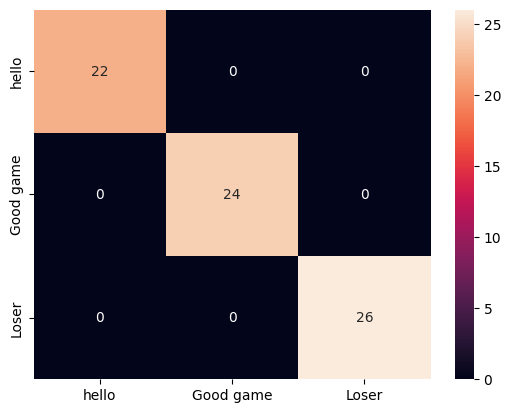

In [34]:
cm = confusion_matrix(ytrue, yhat)
sns.heatmap(cm, annot=True, xticklabels=actions, yticklabels=actions)
plt.show()

In [35]:
print("Training accuracy:", accuracy_score(ytrue, yhat))

Training accuracy: 1.0


## 11. Test in Real Time

In [38]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [37]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'image' is not defined

<Figure size 1800x1800 with 0 Axes>

In [39]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print("Predicted action:", actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0

1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 14ms/step
Predicted action: Good game
1/1 [==============================] - 0s 15ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0

1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 14ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 14ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 33ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [=======

1/1 [==============================] - 0s 11ms/step
Predicted action: hello
1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 11ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [=======

1/1 [==============================] - 0s 11ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [=======

1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [=======

1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 21ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [=======

1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [=======

1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 14ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 14ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 14ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [=======

1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 12ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13ms/step
Predicted action: Good game
1/1 [==============================] - 0s 13

1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 11ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 11ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 11ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [=======

1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 15ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 11ms/step
Predicted action: hello
1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [==============================] - 0s 13ms/step
Predicted action: hello
1/1 [==============================] - 0s 14ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [=======